In [99]:
import nlp_utils
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel
import gensim
import numpy as np
import pandas as pd
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Load parsed news dataset
dataset = nlp_utils.NewsTextDataset()
dataset.load("datasets/tokenized_dataset_2.json")

In [3]:
# Preprocessing
dataset.preprocess()

3999it [00:40, 99.29it/s] 


In [4]:
data = dataset.dump_to_pandas()

In [5]:
data.head()

,category,tokenized_text
0,экономика,"[сооснователь, прошлый, многолетний, руководит..."
1,экономика,"[минэкономразвития, дорабатывать, вносить, пра..."
2,экономика,"[счет, который, открывать, российский, граждан..."
3,экономика,"[российский, рубль, являться, самый, недооцени..."
4,экономика,"[российский, онлайнкинотеатр, откладывать, нео..."


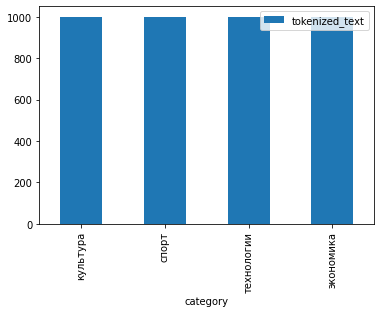

In [6]:
import matplotlib.pyplot as plt
data.groupby('category').count().plot.bar(ylim=0)
plt.show()

In [7]:
from gensim.corpora import Dictionary
def prep_corpus(docs, no_below=3, no_above=0.5):
    dictionary = Dictionary(docs)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()
    print('Creating corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus


#### Create corpus with BOW vectorizer

In [ ]:
dictionary, corpus = prep_corpus(data['tokenized_text'])

#### Create  TFIDF model

In [18]:
from gensim import models

tfidf = models.TfidfModel(corpus, normalize=True)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 3999 documents and 16055 features (575468 matrix non-zeros)


In [19]:
corpus_tfidf = tfidf[corpus]

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Train the model on the TFIDF corpus
lda_tfidf = LdaModel(corpus_tfidf, 
               id2word=dictionary,
               num_topics=4,
               passes=50,
               iterations=50,
               decay=0.75,
               random_state=np.random.RandomState(42));

In [ ]:
# Trying to add GridSearch
from gensim.test.utils import common_corpus, common_dictionary
from gensim.sklearn_api import LdaTransformer
from sklearn.model_selection import GridSearchCV
param_grid = {'num_topics': [4, 8, 16, 32],
               'passes': [10, 50, 100],
               'iterations':[50, 100, 500],
               'decay': [0.5, 0.75, 0.9]
               }
# Reduce each document to 2 dimensions (topics) using the sklearn interface.
model = LdaTransformer(id2word=dictionary)
sh = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=10).fit(corpus)

In [ ]:
# Train the model on the BOW corpus.
lda = LdaModel(corpus, 
               id2word=dictionary,
               num_topics=4,
               passes=50,
               iterations=50,
               decay=0.75,
               random_state=np.random.RandomState(42))

### Visalize result with BOW LDA model

In [11]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [12]:
pyLDAvis.display(vis_data)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visalize result with TFIDF LDA model

In [22]:
vis_data_tfidf = gensimvis.prepare(lda_tfidf, corpus_tfidf, dictionary)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
pyLDAvis.display(vis_data_tfidf)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def generate_wordcloud(lda_model):
    for t in range(lda_model.num_topics):
        plt.figure()
        plt.imshow(WordCloud(background_color="white").fit_words(dict(lda_model.show_topic(t, 50))))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Wordclouds for BOW LDA model

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


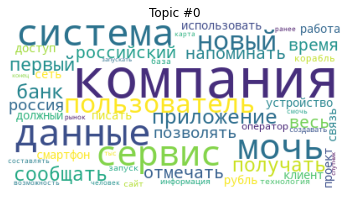

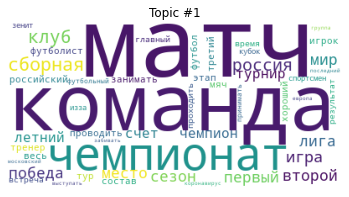

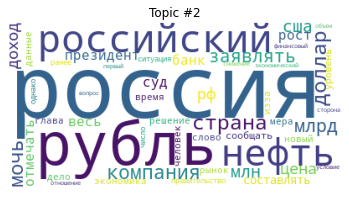

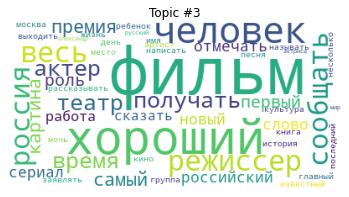

In [69]:
generate_wordcloud(lda)

### Wordcloud for TFIDF LDA model

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


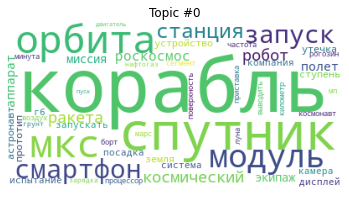

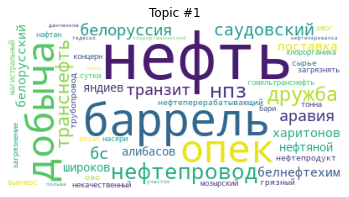

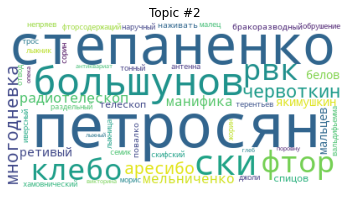

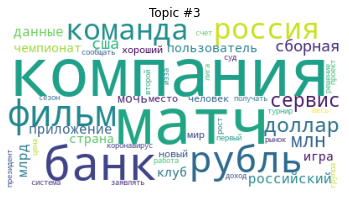

In [70]:
generate_wordcloud(lda_tfidf)

### Coherence Score Calculation for BOW LDA model

In [ ]:
import gensim.downloader as api
from gensim.models.coherencemodel import CoherenceModel
w2v_model = api.load("word2vec-ruscorpora-300")

In [ ]:
cleaned_w2v_dict = {k.split('_')[0]: v for k, v in w2v_model.vocab.items()}
w2v_model.vocab = cleaned_w2v_dict

In [53]:
coherence_model_lda_w2v_bow = CoherenceModel(model=lda, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_w2v',keyed_vectors=w2v_model)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
coherence_lda = coherence_model_lda_w2v_bow.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5322943


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Coherence Score Calculation for TFIDF LDA model

In [56]:
coherence_model_lda_w2v_tfidf = CoherenceModel(model=lda_tfidf, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_w2v',keyed_vectors=w2v_model)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
coherence_lda = coherence_model_lda_w2v_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.5410596


## Task 3

In [96]:
# Genereate input for word2vec
from sklearn.manifold import TSNE
def generate_w2vec_scatterplot(lda_model):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for top_num in range(lda_model.num_topics):
        vocab =  [word for word, valure in lda_model.show_topic(top_num, 10)]
        X = w2v_model[vocab]

        tsne = TSNE(n_components=2)
        X_tsne = tsne.fit_transform(X)
        df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
        ax.scatter(df['x'], df['y'])
        for word, pos in df.iterrows():
            ax.annotate(word, pos)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: "word 'большунов' not in vocabulary"

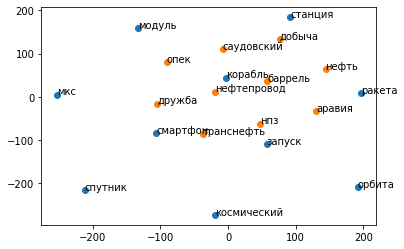

In [97]:
generate_w2vec_scatterplot(lda_tfidf)

## PLSA

In [114]:
from nltk.corpus import stopwords
from plsa.preprocessors import *

RUSSIAN_DEFAULT_PIPELINE = (
    tokenize,
    remove_short_words(2),
)

In [104]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA
import csv
from numpy import zeros, ndarray, log, sign, abs
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [115]:
plsa_corpus_csv = data.copy()
for i, string in enumerate(plsa_corpus_csv['tokenized_text']):
    plsa_corpus_csv.iloc[i]['tokenized_text'] = ' '.join(string)

In [116]:
# plsa_corpus_csv['tokenized_text'] = plsa_corpus_csv['tokenized_text']
plsa_corpus_csv.to_csv('datasets/corpus.csv')

In [117]:
pipeline = Pipeline(*RUSSIAN_DEFAULT_PIPELINE)
corpus = Corpus.from_csv('datasets/corpus.csv', pipeline, col=-1, encoding='utf-8', max_docs=10000)
corpus

Corpus:
Number of documents: 3999
Number of words:     39099

In [118]:
n_topics = 4

In [119]:
plsa = PLSA(corpus, n_topics, True)
plsa

PLSA:
====
Number of topics:     4
Number of documents:  3999
Number of words:      39099
Number of iterations: 0

In [ ]:
result = plsa.fit()